# Example of creating a new system from scratch
In this notebook we show how to add a new experiment (in this case simulated) and analysis tools to the framework. We consider a biological system governed buy predator-prey dynamics.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sciexplorer.tool_utils import get_image # this function is needed to return images to the agent
from sciexplorer.model_utils import Model
from sciexplorer.run_exp import run_experiment

## Creating an experiment

In [14]:
class BlackBoxSystem():
    """Lotka-Volterra system describing predator-prey dynamics as black box simulator."""
    
    def __init__(self, a=1.0, b=0.1, c=1.5, d=0.075, dt=0.1, num_steps=1000, steps_per_timestep=10):
        self.a = a  # Prey growth rate
        self.b = b  # Predation rate
        self.c = c  # Predator death rate
        self.d = d  # Predator reproduction rate
        self.dt = dt # Time step for integration
        self.num_steps = num_steps # Number of time steps to simulate
        # The description will be shown to the agent when initializing the experiment
        self.description = "In this system, you can observe the population dynamics of two species in an experimental biological system."
        self.steps_per_timestep = steps_per_timestep # Number of internal solver steps per time step (not used in this simple Euler method)

    def step(self, state):
        """Perform one time step using Euler's method."""
        prey, predator = state
        for _ in range(self.steps_per_timestep):
            dprey = (self.a * prey - self.b * prey * predator) * (self.dt / self.steps_per_timestep)
            dpredator = (self.d * prey * predator - self.c * predator) * (self.dt / self.steps_per_timestep)
            prey += dprey
            predator += dpredator
        return np.array([prey, predator])
    
    def observe_dynamics(self, init0:float, init1:float) -> dict:
        # This is a tool. Its docstring and typehints will be automatically parsed to create the tool description for the agent.
        # Therefore, we cannot provide any hints about the system here.
        # Additionally, the final tool description will automatically ask the agent to provide a label under which the result should be saved.
        # Tools always need to return dictionaries!
        """Observe the dynamics of the system given initial conditions.
        Args:
            init0: Initial condition one.
            init1: Initial condition two
        Returns:
            states (np.ndarray): Array containing the states at each time step.
            times (np.ndarray): Array containing the time points.
        """
        states = [np.array([init0, init1])]
        for _ in range(self.num_steps):
            new_state = self.step(states[-1])
            states.append(new_state)
        return {"states": np.array(states), "times": np.arange(len(states))*self.dt}
    
    def save_result(self, result:str) -> dict:
        # This is a tool. Its docstring and typehints will be automatically parsed to create the tool description for the agent.
        # As above, the tool needs to return a dictionary.
        """Save your predicted equation of motion for the system.
        Args:
            result: python code as a string the defines the following function:
                def equation_of_motion(state: np.ndarray) -> np.ndarray:
                    # state is a numpy array of shape (2,) containing the current state [s0, s1]
                    # The function should return a numpy array of shape (2,) containing the time derivative [ds0/dt, ds1/dt]
                    return np.array([ds0_dt, ds1_dt])
        Returns:
            Message that the result was saved.
        """
        # You may add some code to automaticcally validate the result here.
        self.last_result = {"predicted_eom": result}
        return {"message": "Result saved successfully."}



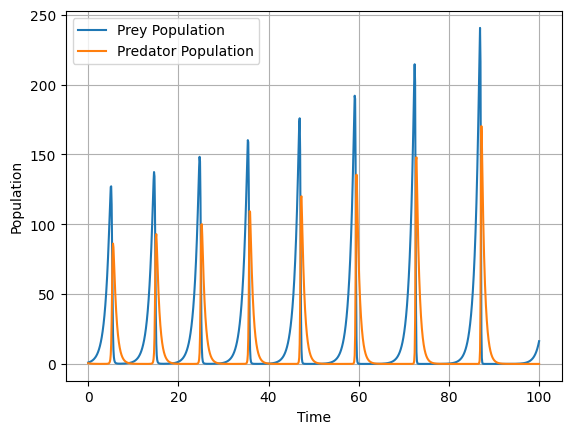

In [15]:
experiment = BlackBoxSystem()
dynamics = experiment.observe_dynamics(1,0.5)

plt.plot(dynamics['times'], dynamics['states'][:,0], label='Prey Population')
plt.plot(dynamics['times'], dynamics['states'][:,1], label='Predator Population')
plt.xlabel('Time')
plt.ylabel('Population')
plt.grid(True)
plt.legend()
plt.show()


# Creating an analysis tool

In [16]:
def only_plot(_fields:dict, use_legend:str, x_label_list:str, y_label_list:str, x_idcs_list:str, y_idcs_list:str) -> dict:
    # This is an analysis tool. Its docstring and typehints will be automatically parsed to create the tool description for the agent.
    # When using _fields as an input argument, the framework will automatically pass all previously saved fields to the tool.
    # As above, the tool needs to return a dictionary.
    """
    Plot two previously saved arrays against each other.
    Args:
        use_legend: whether to use a legend in the plot, either "True" or "False"
        x_label_list: list of result_labels of the x arrays to plot, in the form "['label1', 'label2', ...]"
        y_label_list: list of result_labels of the y arrays to plot, in the form "['label1', 'label2', ...]"
        x_idcs_list: list of indices of the x arrays to plot (as a string), in the form "['[idx1_label1, :, ...]', '[idx1_label2, :, ...]', ...]", where idx1 is an integer index and : means all indices.
        y_idcs_list: list of indices of the y arrays to plot (as a string), in the form "['[idx1_label1, :, ...]', '[idx1_label2, :, ...]', ...]", where idx1 is an integer index and : means all indices.
    For example, to plot the first row of two-dimensional array 'states1' against the one-dimensional array 'times1', 
    and the second row of two-dimensional array 'states2', against the one-dimensional array 'times2' ,you would call:
        plot_only("['times1', 'times2']", "['states1', 'states2']", "['[:]', '[:]']", "['[0, :]', '[1, :]']")
    This would plot states1[0,:] vs times1.
    Returns:
        Image
    """

    if use_legend == "True":
        use_legend = True
    elif use_legend == "False":
        use_legend = False
    else:
        raise ValueError("use_legend must be either 'True' or 'False'.")
    plt.figure(figsize=(8,6))
    try:
        x_label_list = eval(x_label_list)
    except Exception as e:
        # Try to create descriptive error messages, as these will be passed to the agent for debugging.
        raise ValueError(f"Error while evaluating x_label_list: {e}")
    try:
        y_label_list = eval(y_label_list)
    except Exception as e:
        raise ValueError(f"Error while evaluating y_label_list: {e}")
    try:
        x_idcs_list = eval(x_idcs_list)
    except Exception as e:
        raise ValueError(f"Error while evaluating x_idcs_list: {e}")
    try:
        y_idcs_list = eval(y_idcs_list)
    except Exception as e:
        raise ValueError(f"Error while evaluating y_idcs_list: {e}")
    assert isinstance(x_label_list, list), "x_label_list must be a list of strings."
    assert isinstance(y_label_list, list), "y_label_list must be a list of strings."
    if len(x_label_list) != len(y_label_list):
        raise ValueError("x_label_list and y_label_list must have the same length.")
    for x_label, y_label, x_idcs, y_idcs in zip(x_label_list, y_label_list, x_idcs_list, y_idcs_list):
        x_data = _fields.get(x_label, None)
        y_data = _fields.get(y_label, None)
        if x_data is None:
            raise ValueError(f"No field with label {x_label} found.")
        if y_data is None:
            raise ValueError(f"No field with label {y_label} found.")
        try:
            x_to_plot = eval(f"x_data{x_idcs}")
            y_to_plot = eval(f"y_data{y_idcs}")
        except Exception as e:
            raise ValueError(f"Error while indexing the data with {x_idcs} and {y_idcs}: {e}")
        try:
            plt.plot(x_to_plot, y_to_plot, linestyle='-', label=f"{y_label}{y_idcs} vs {x_label}{x_idcs}")  
        except Exception as e:
            raise ValueError(f"Error while plotting {y_label} vs {x_label}: {e}")
    plt.xlabel("X")
    plt.ylabel("Y")
    if use_legend:
        plt.legend()
    plt.grid()
    result=get_image()
    return {'image': result}

# Running the experiment

In [ ]:
# create the LLM model
model = Model(
    api_key = '',  # add your OpenAI API key here
    base_url=None,
    model_name='gpt-5',
)

--Setting simulator tools: [<bound method BlackBoxSystem.observe_dynamics of <__main__.BlackBoxSystem object at 0x1550035f0>>]--
--Setting analysis tools: [<function only_plot at 0x13775b920>]--
--Running experiment--
Timeout for function calls set to: 30
SYSTEM: You are a cautious theoretical biologist
USER: In this system, you can observe the population dynamics of two species in an experimental biological system.
Can you find the equations of motion that govern the dynamics of this system?
You can reason for up to 20 steps and call up to 40 tools to help you find the answer.
After your exploration please call the tool save_result to provide your final answer.
USER: 
 You potentially have up to 20 steps left and can call up to 40 tools. If already present, what do the past tool results teach you about the question?
Describe which tool you want to call next and why you want to call it in plain text.
ASSISTANT REASONING: **Planning dynamic observations**

I see that the system will pro

({'predicted_eom': 'import numpy as np\n\ndef equation_of_motion(state: np.ndarray) -> np.ndarray:\n    # Let state = [x, y]\n    x, y = state\n    # Parameters inferred from invariance and approximate nullclines\n    alpha = 1.0          # intrinsic growth of x (prey)\n    beta = 1.0 / 120.0   # interaction strength (prey loss per predator)\n    gamma = 1.0          # intrinsic mortality of y (predator)\n    delta = 0.1          # conversion/interaction (predator growth per prey)\n\n    dxdt = alpha * x - beta * x * y\n    dydt = delta * x * y - gamma * y\n    return np.array([dxdt, dydt])\n'},
 [{'role': 'system', 'content': 'You are a cautious theoretical biologist'},
  {'role': 'user',
   'content': 'In this system, you can observe the population dynamics of two species in an experimental biological system.\nCan you find the equations of motion that govern the dynamics of this system?\nYou can reason for up to 20 steps and call up to 40 tools to help you find the answer.\nAfter you
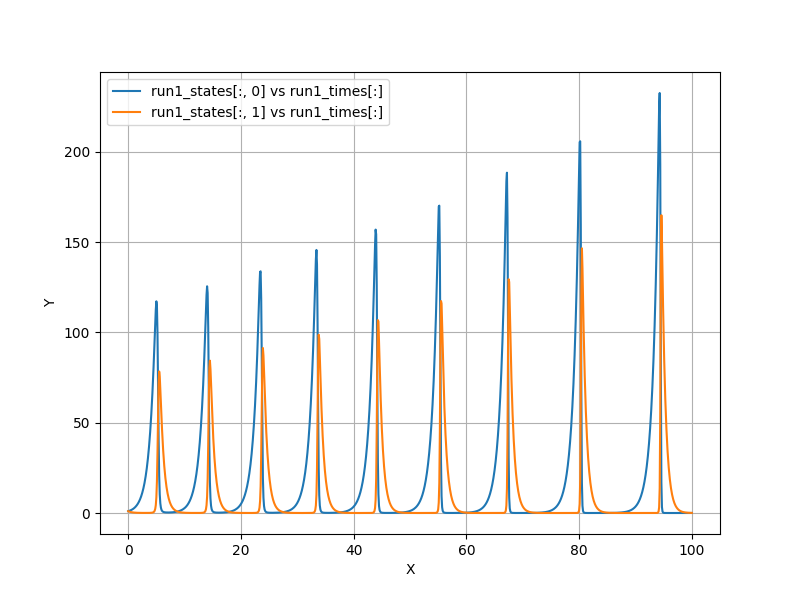
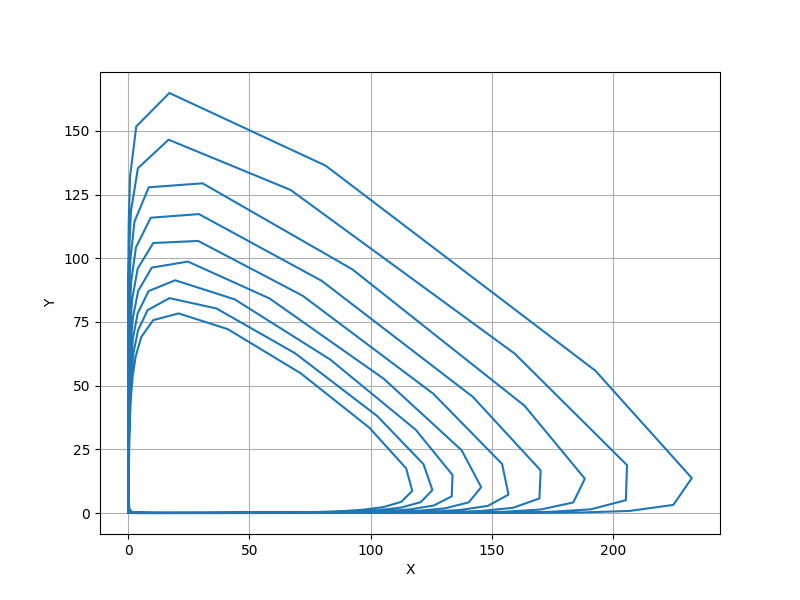
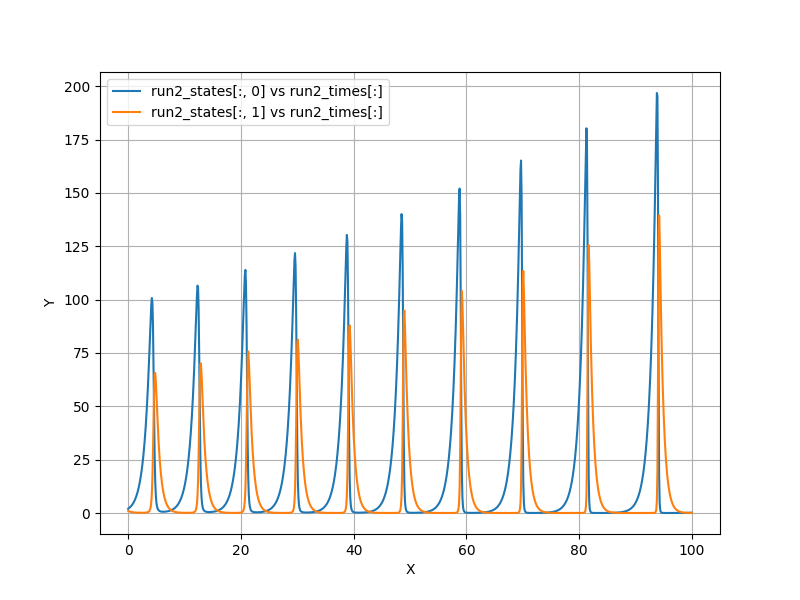
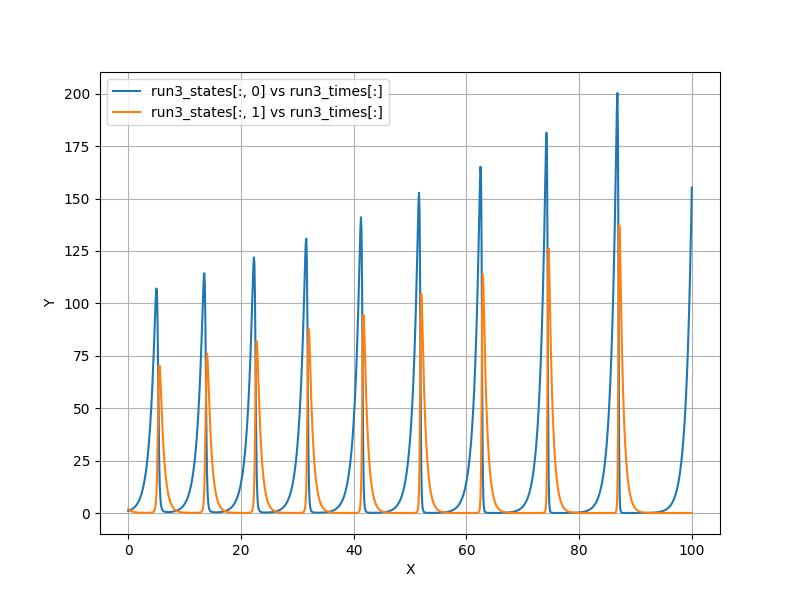
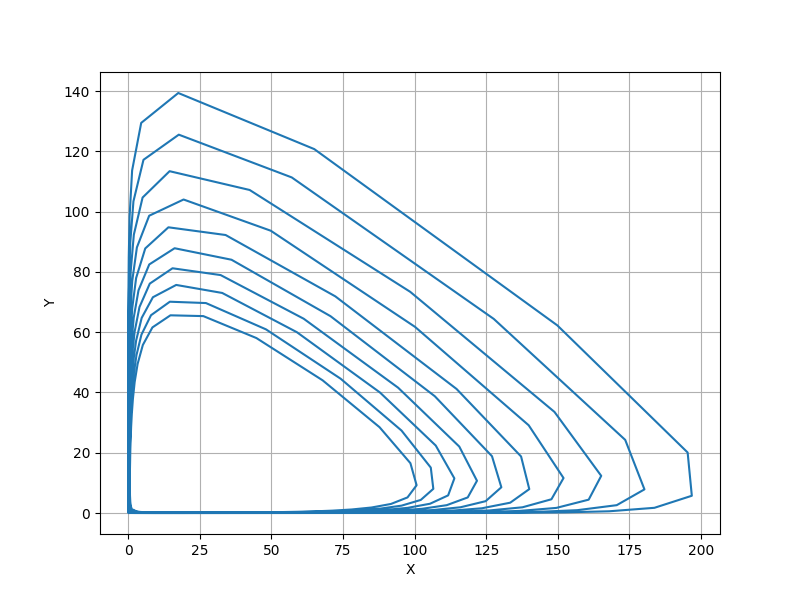
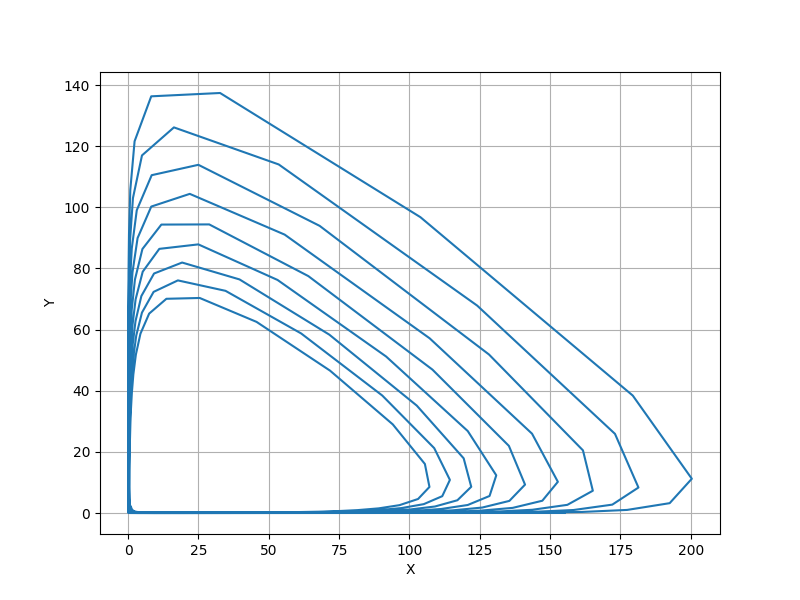
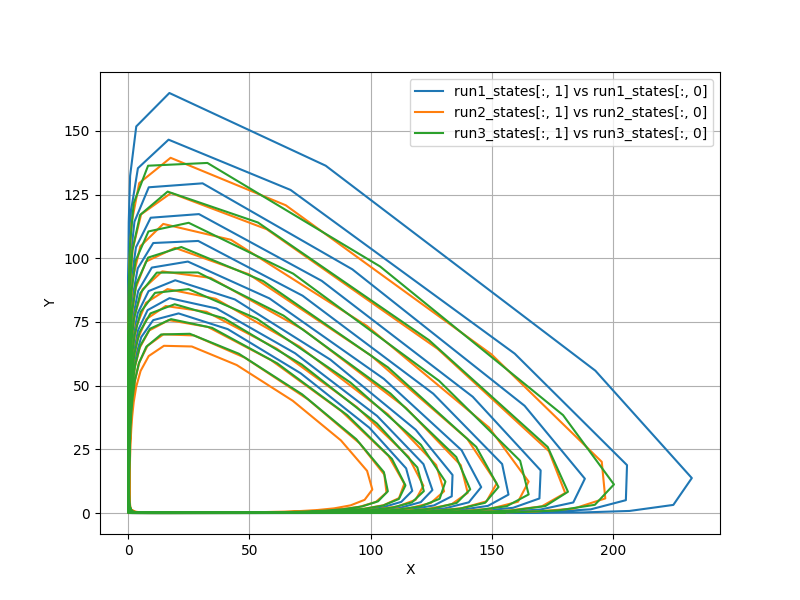
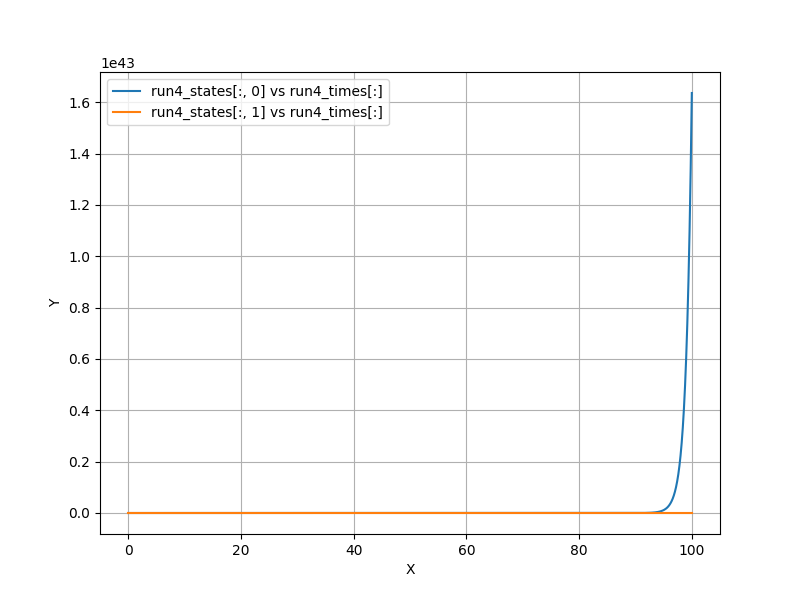
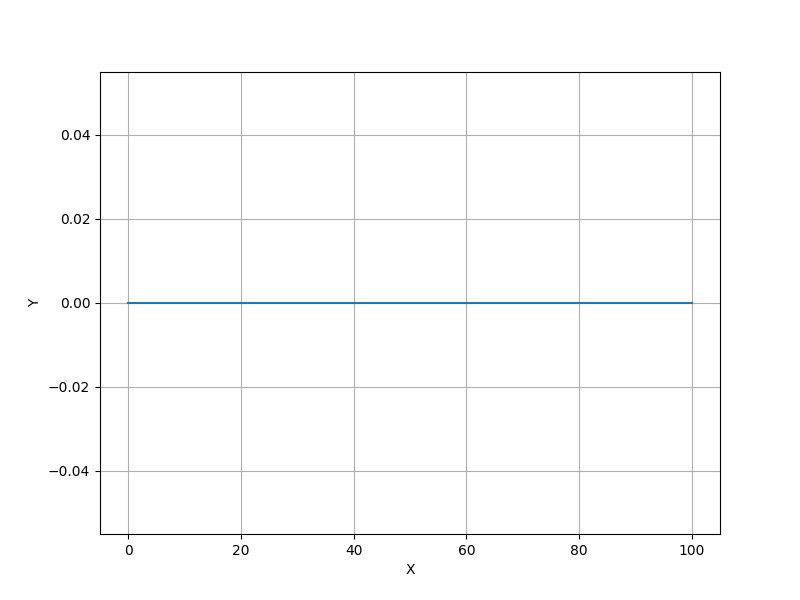
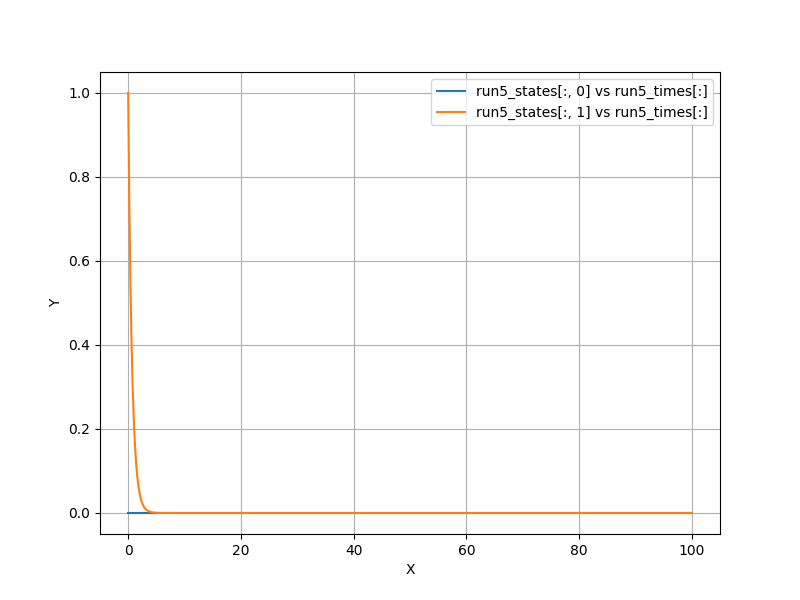
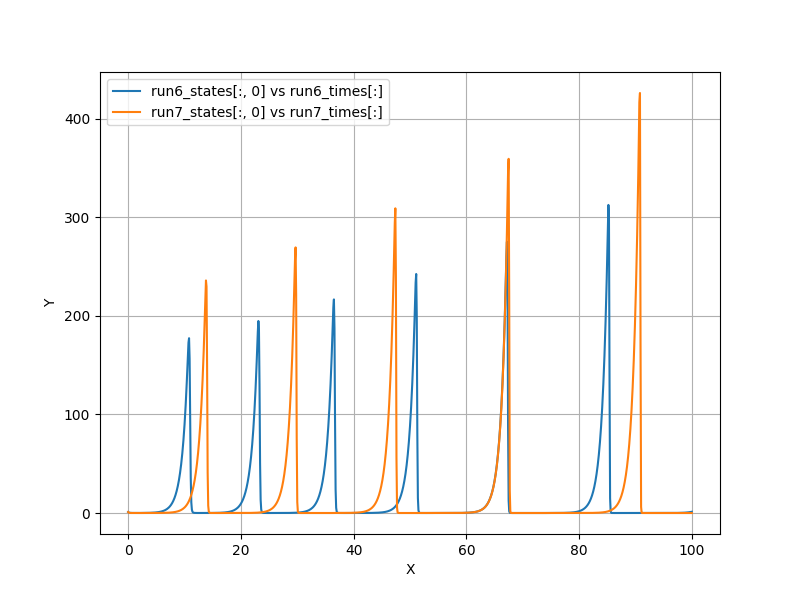
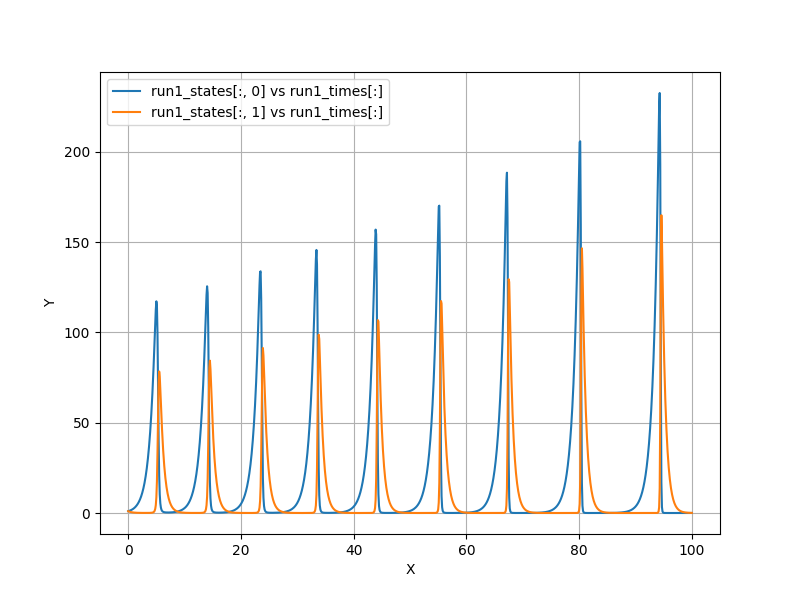
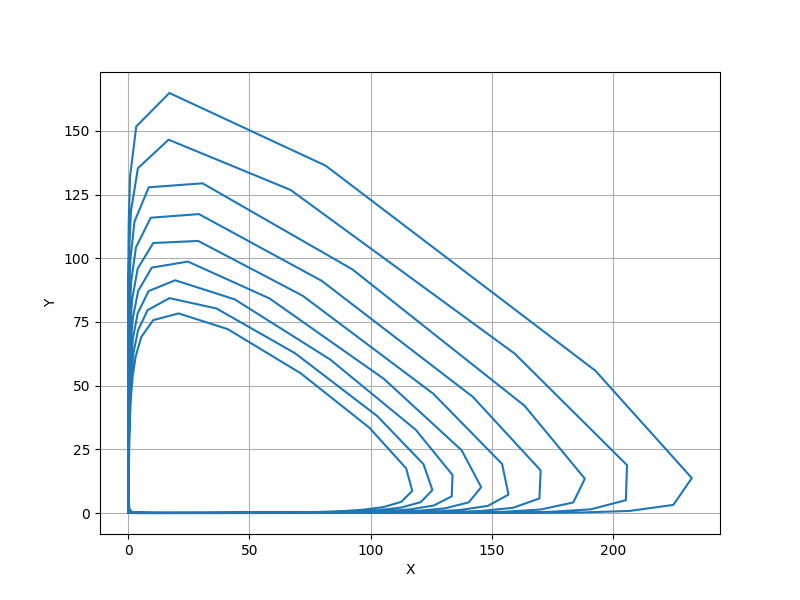
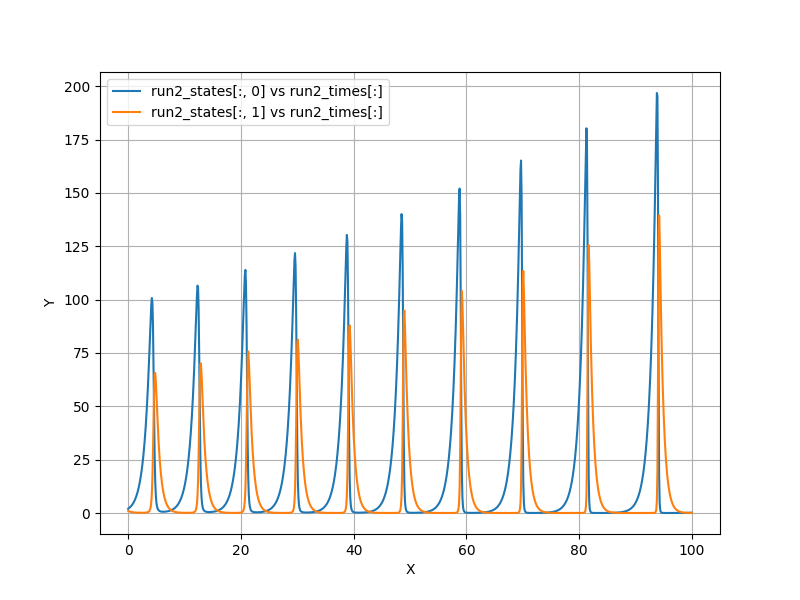
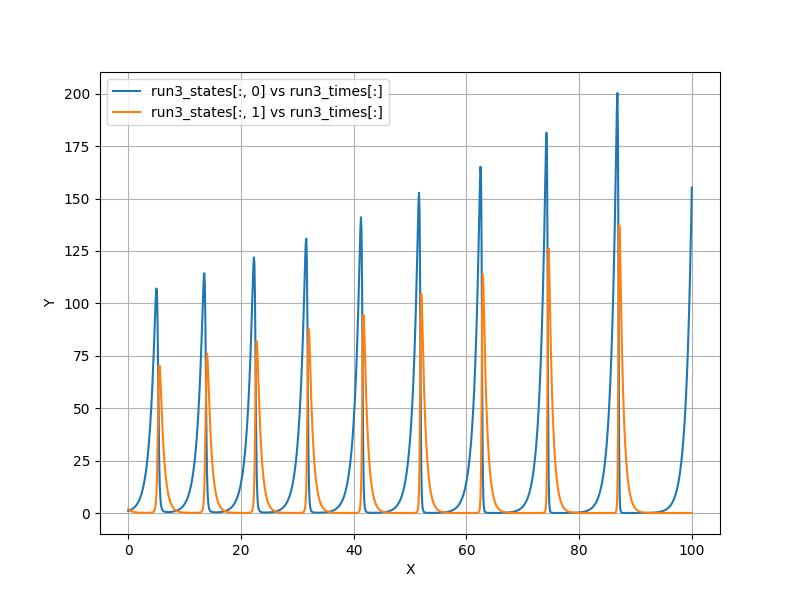
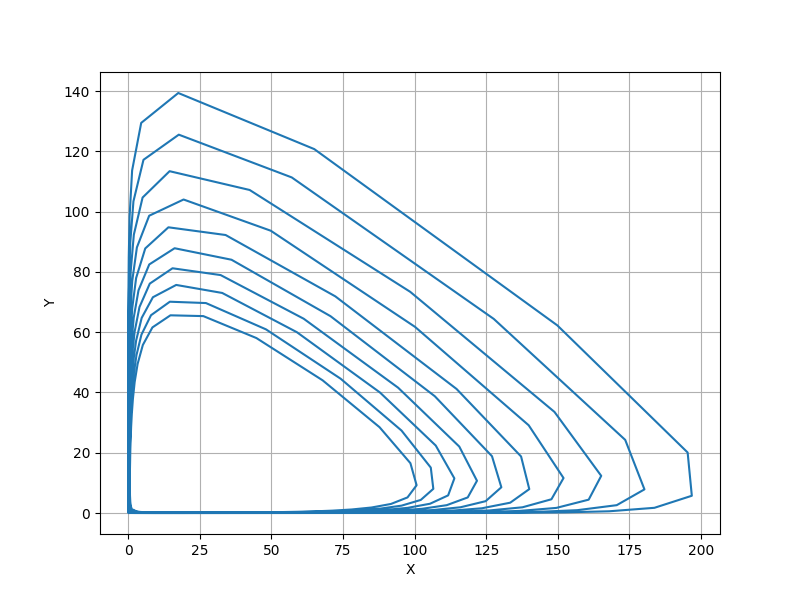
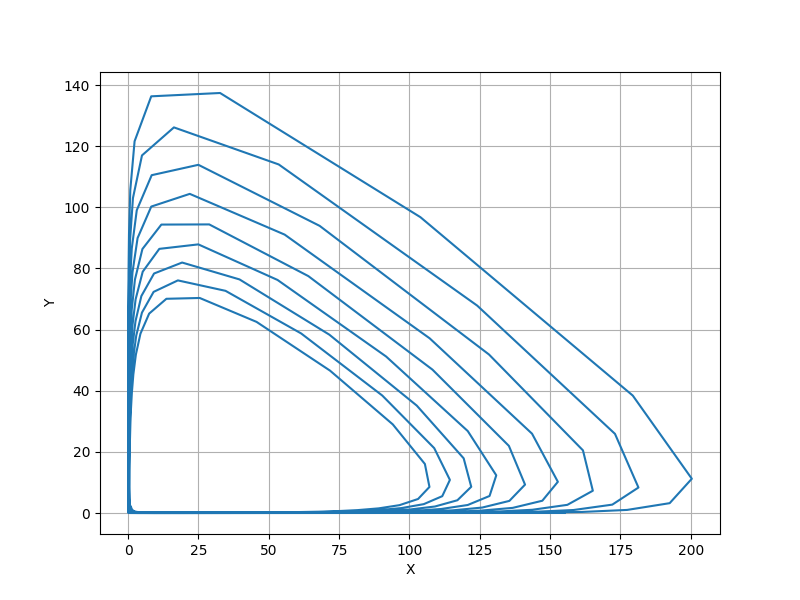
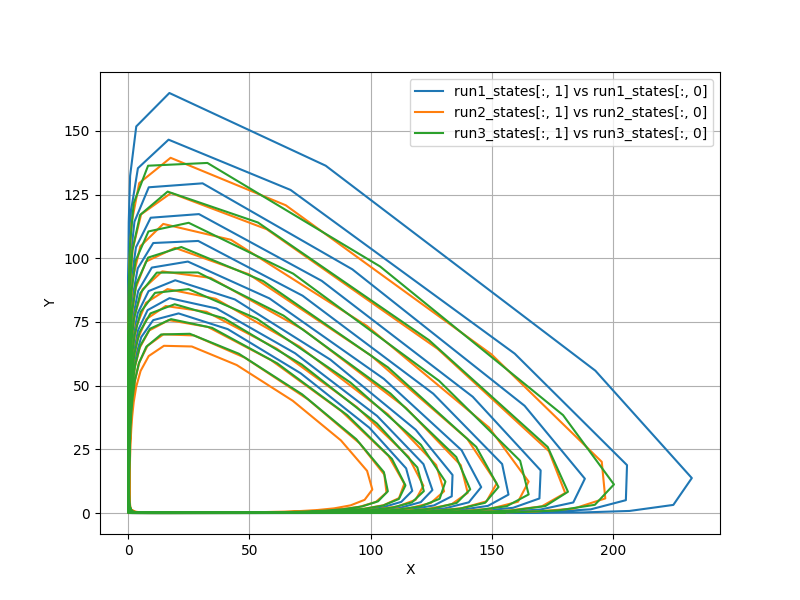
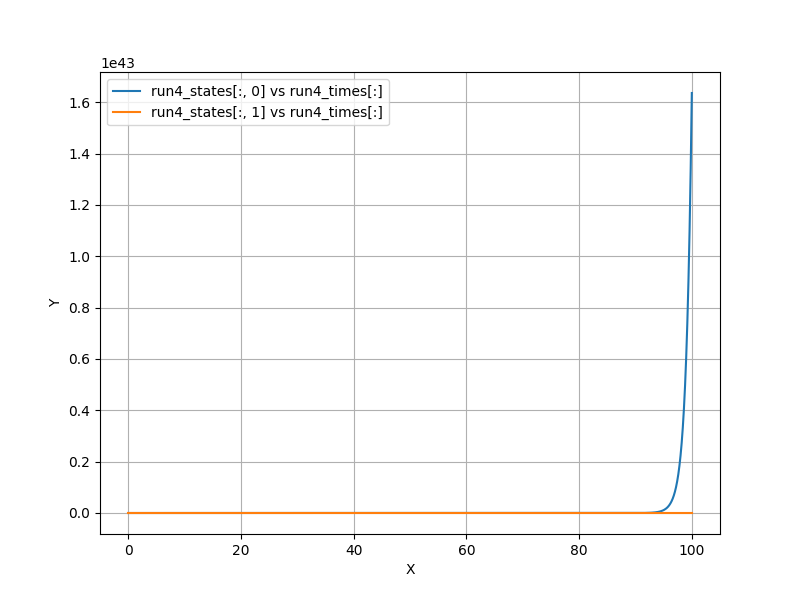
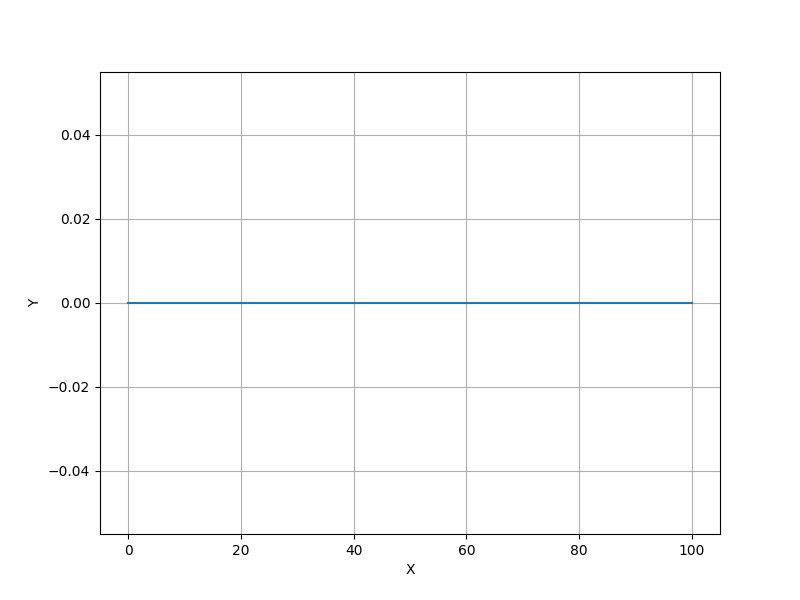
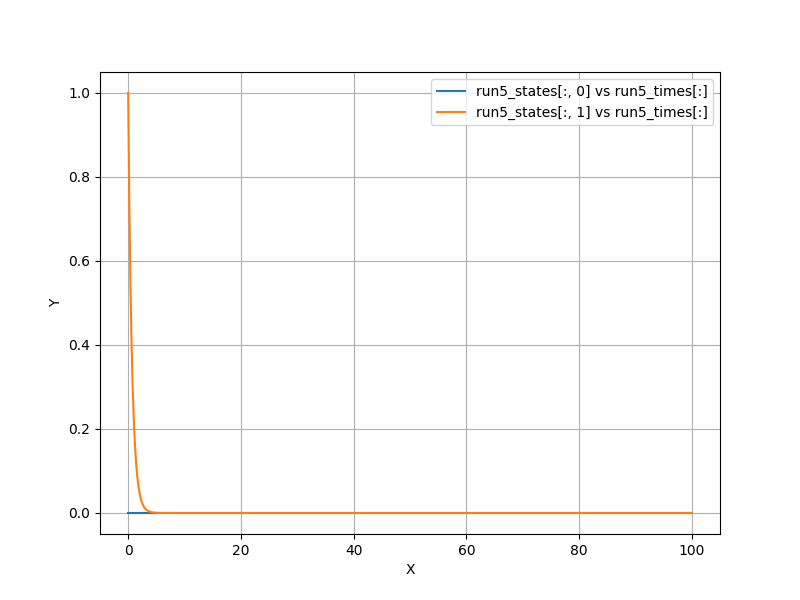
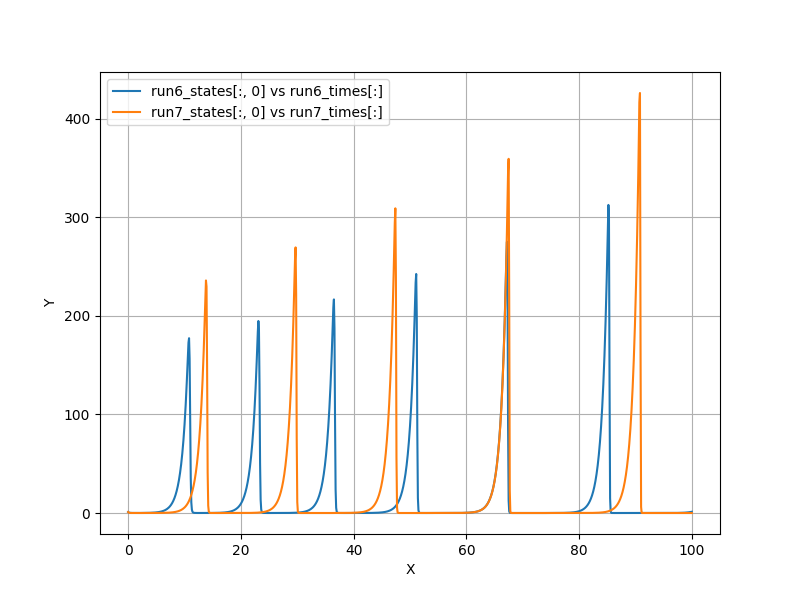

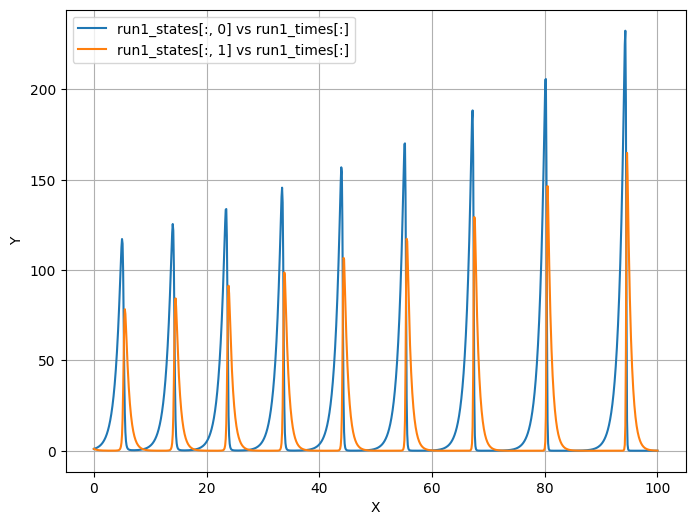

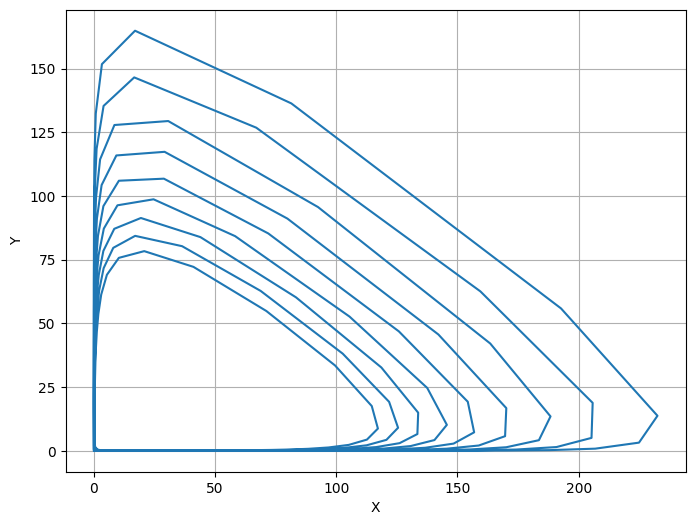

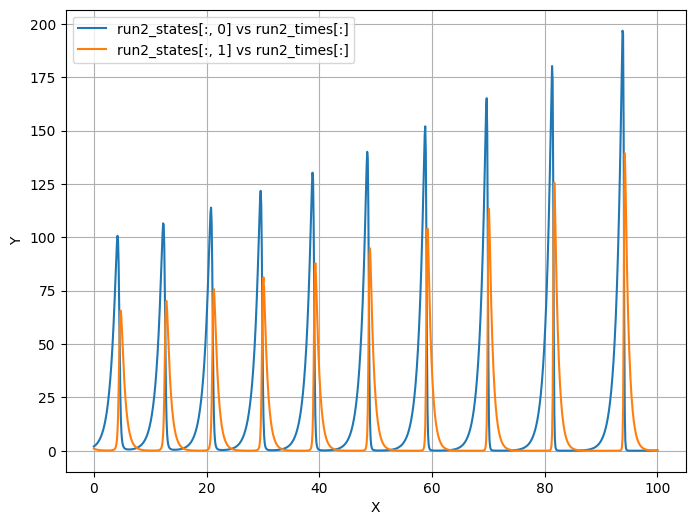

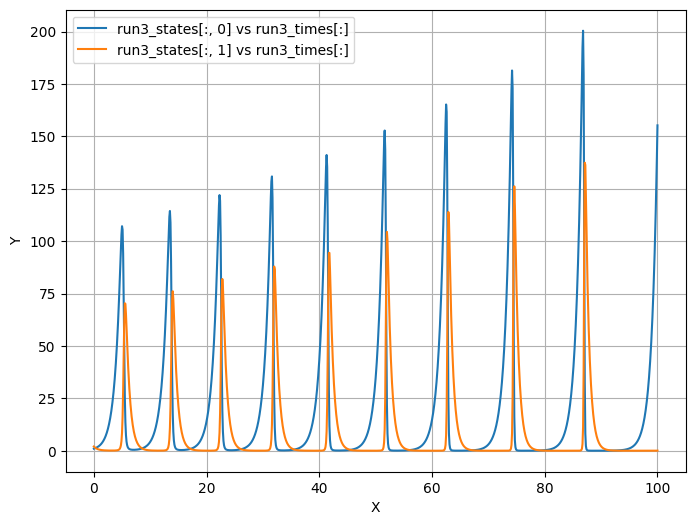

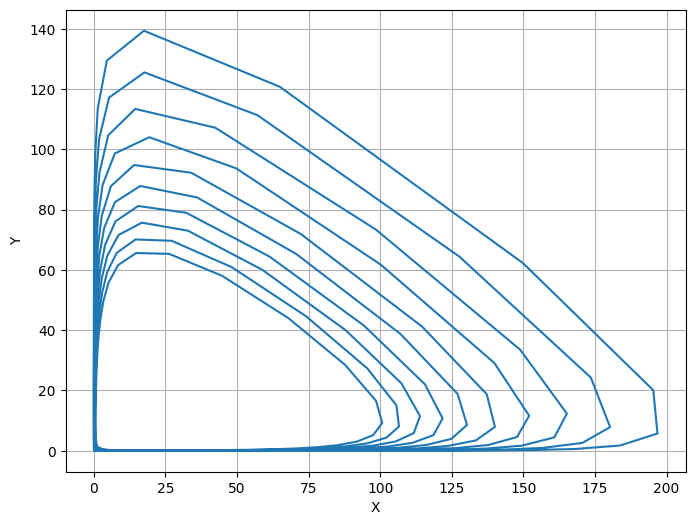

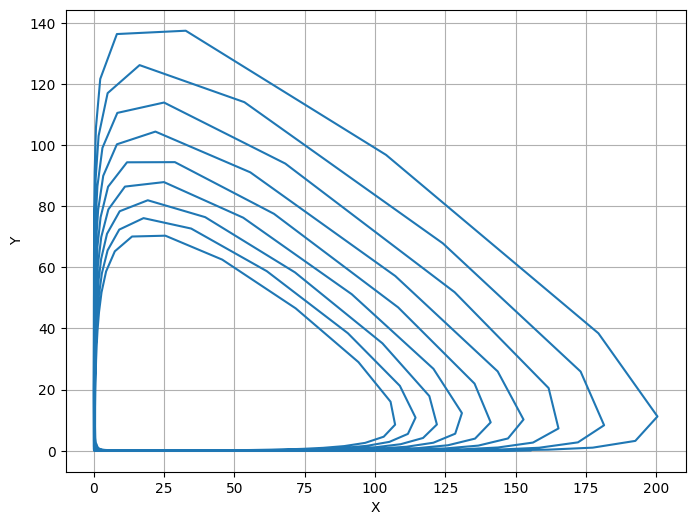

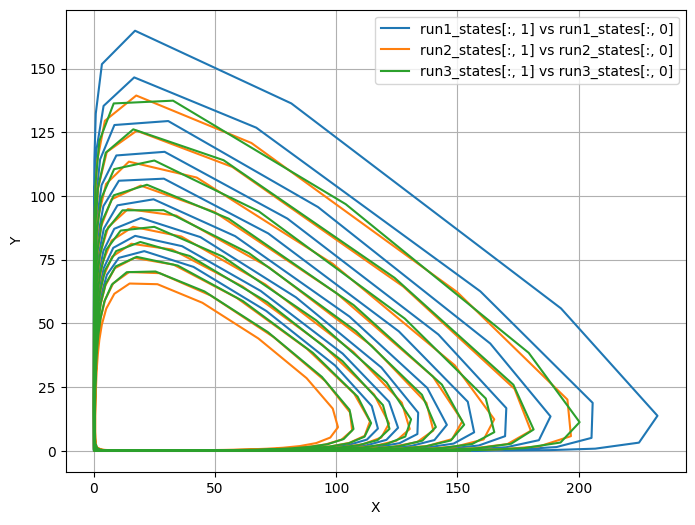

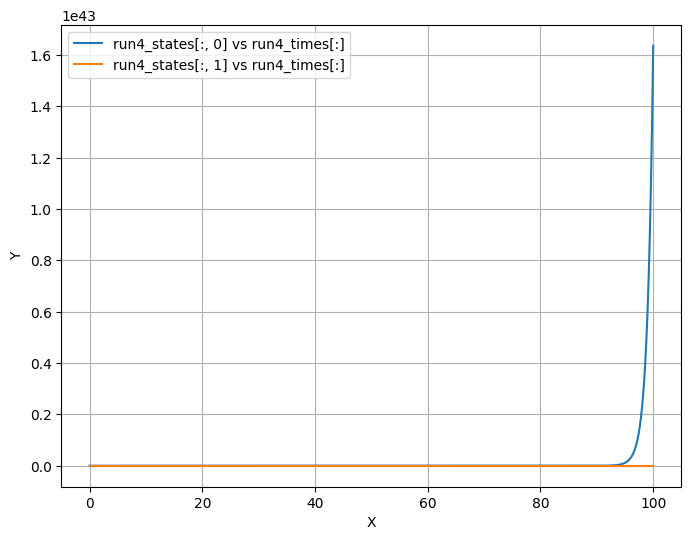

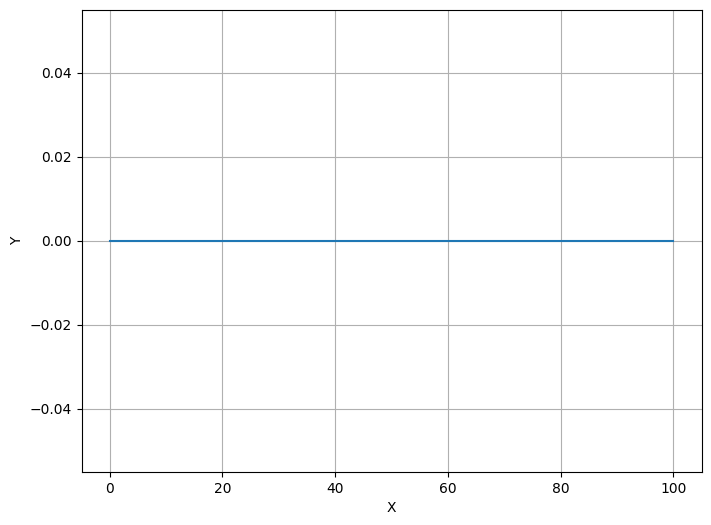

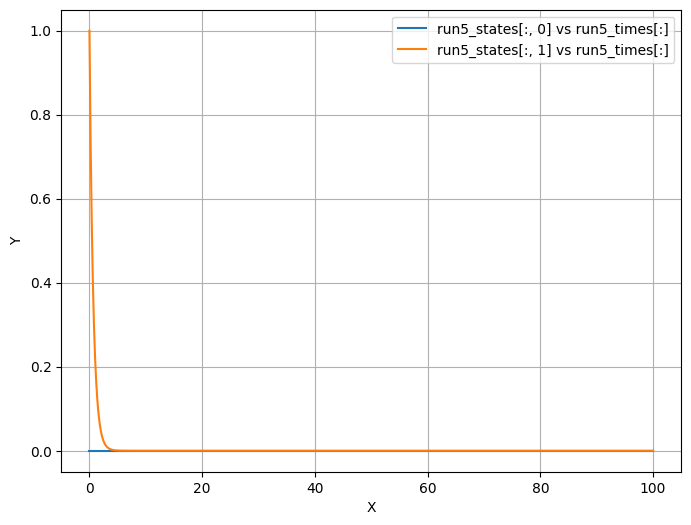

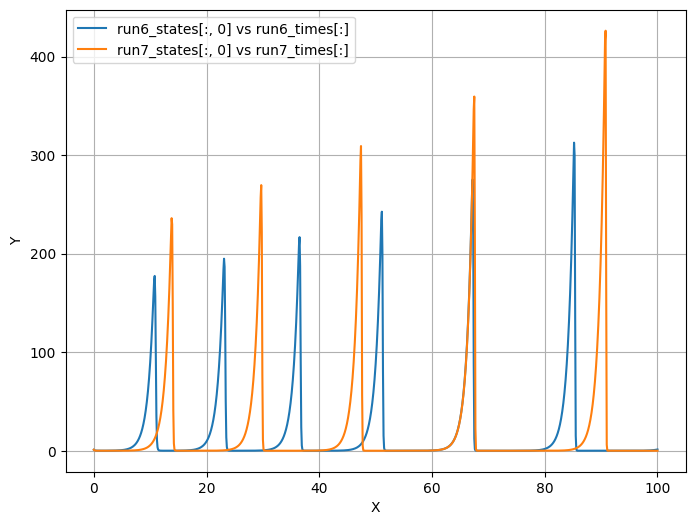

In [11]:
run_experiment(model=model,
                task_prompt="Can you find the equations of motion that govern the dynamics of this system?",
                simulator=experiment, # initialized simulator object
                simulator_tools = ['observe_dynamics'], # the tools of the simulator that the agent can use as strings
                analysis_tools = [only_plot], # the analysis tools that the agent can use, here we pass the function directly
                run_kwargs=dict(
                            allow_multiple_tool_calls = True, # allow the agent to call multiple tools in one step
                            max_steps = 20, max_tools = 40 # maximum number of steps and tools the agent can use in one run
                            ),
                random_exp_func=None, # not needed here, as we do not want to run intial random experiments
                plot_function=None, # not needed here, as we do not want to run intial random experiments
                n_exps_to_run= 0, ## not needed here, as we do not want to run intial random experiments
                result_tool = "save_result", # the tool to save the final result should be a method of the simulator
                system_prompt= "You are a cautious theoretical biologist",  
                intermediate_prompts={'ask_for_reasoning': {"content": f"""If already present, what do the past tool results teach you about the question?
Describe which tool you want to call next and why you want to call it in plain text."""},
                                       'ask_for_tool_use': {"content": """THIS IS NOT NEEDED IF separate_tool_calls=False."""},
                                        'wrong_format_tool_call': {"content": """THIS IS NOT NEEDED IN RESPONSE API."""},
                                        'ask_final_answer': {"content": f"""Please provide a final answer without using any tools."""}},
                summarize_at_end=True, # summarize the experiment at the end of the run
                separate_tool_calls=False, # Whether to separate tool calls from reasoning steps
                response_api=True, # Use the response API or ChatCompletion API
                reasoning_level="high", # Level of reasoning to use: low, medium, high
                verbosity="high", # Level of verbosity: low, medium, high
                reasoning_summary="auto", # Create summary of internal reasoning at each step
                timeout=30, # timeout for each tool evaluation in seconds
)